In [1]:
!pip install -r requirements.txt


In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:

# Put the dataset files in the same folder as this notebook (or update paths here).
DATA_PATH = r"C:\UIU_Code\test-dataset.xlsx - test data.csv"
DESC_PATH = r"C:\UIU_Code\dataset_variable_description.xlsx - Sheet1.csv"

df = pd.read_csv(DATA_PATH)
desc = pd.read_csv(DESC_PATH)

print("Dataset shape:", df.shape)
display(desc.head())
display(df.head())


Dataset shape: (29999, 34)


,Columns name,Description
0,household_id,Unique Id indicating a single household
1,total_income,Position in the income quartile of a household
2,union_name,Name of the Union where the household situated
3,user_id,Unique Id indicating a single user
4,profile_name,Name of the user


,Unnamed: 0,household_id,total_income,union_name,user_id,profile_name,father_name,mother_name,birthday,age,...,RESULT_STAT_BMI,SUGAR,TAG_NAME,RESULT_STAT_SUGAR,PULSE_RATE,RESULT_STAT_PR,SPO2,RESULT_STAT_SPO2,MUAC,RESULT_STAT_MUAC
0,1,241175,Lower class,KOLA,988794,মো: সাগরহোসেন,0.0,0.0,2001-11-05 18:00:00,19,...,NaN,NaN,NaN,NaN,96.0,Normal,97.0,Normal,NaN,NaN
1,2,241176,Lower class,KOLA,988796,মোছা:তামান্না,0.0,0.0,2000-06-18 18:00:00,20,...,NaN,NaN,NaN,NaN,89.0,Normal,NaN,NaN,NaN,NaN
2,3,241179,Lower class,KOLA,988802,শুকুরুচন্দ্র,0.0,0.0,1978-06-04 18:00:00,42,...,NaN,NaN,NaN,NaN,69.0,Normal,NaN,NaN,NaN,NaN
3,4,241180,Lower class,KOLA,988807,দিপালীরাণী,0.0,0.0,1956-02-02 18:00:00,64,...,NaN,8.72,Random,Normal,85.0,Normal,NaN,NaN,NaN,NaN
4,5,241181,Lower class,KOLA,988809,বুলবুলি,0.0,0.0,1996-12-25 18:00:00,23,...,NaN,NaN,NaN,NaN,101.0,High,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  29999 non-null  int64  
 1   household_id                29999 non-null  int64  
 2   total_income                29999 non-null  object 
 3   union_name                  29999 non-null  object 
 4   user_id                     29999 non-null  int64  
 5   profile_name                29999 non-null  object 
 6   father_name                 25561 non-null  object 
 7   mother_name                 25547 non-null  object 
 8   birthday                    29999 non-null  object 
 9   age                         29999 non-null  int64  
 10  gender                      29999 non-null  object 
 11  is_poor                     29999 non-null  int64  
 12  is_freedom_fighter          29999 non-null  int64  
 13  had_stroke                  299

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,29999.0,NaN,NaN,NaN,15000.0,8660.109699,1.0,7500.5,15000.0,22499.5,29999.0
household_id,29999.0,NaN,NaN,NaN,220657.30251,158927.210137,12300.0,81244.5,219654.0,279809.5,786118.0
total_income,29999,4,Lower class,19975,NaN,NaN,NaN,NaN,NaN,NaN,NaN
union_name,29999,16,CHERAGPUR,6227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,29999.0,NaN,NaN,NaN,978483.285143,808133.038002,96804.0,351611.0,905099.0,1122635.0,4040559.0
profile_name,29999,17168,মনোয়ারাবেগম,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
father_name,25561,4710,0,17143,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mother_name,25547,3701,0,16583,NaN,NaN,NaN,NaN,NaN,NaN,NaN
birthday,29999,22828,1985-03-10 00:00:00,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,29999.0,NaN,NaN,NaN,38.637621,17.494271,0.0,26.0,37.0,50.0,120.0


,missing_rate
RESULT_STAT_MUAC,0.997533
MUAC,0.997533
WEIGHT,0.962399
BMI,0.962399
RESULT_STAT_BMI,0.962399
HEIGHT,0.962399
RESULT_STAT_SUGAR,0.947232
SUGAR,0.947232
TAG_NAME,0.947232
RESULT_STAT_SPO2,0.855162


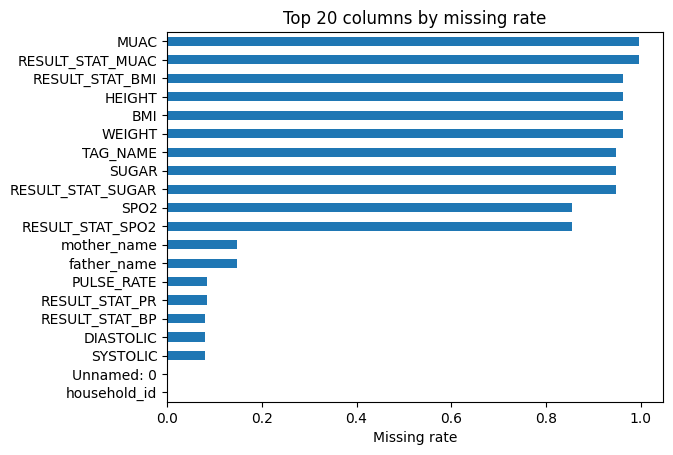

user_id unique: 29999  / rows: 29999
household_id unique: 21449

 gender


gender
Female    23236
Male       6763
Name: count, dtype: int64


 total_income


total_income
Lower class           19975
Middle class           6262
Lower-middle class     3052
Upper class             710
Name: count, dtype: int64


 union_name


union_name
CHERAGPUR             6227
SHASHORA              5575
BARATARA              3700
ANDULBARIA            2118
BILASHBARI            1922
SAGHATA               1690
KOLA                  1678
ELANGI                1589
ELIOTGANJ  DAKKHIN    1489
TENTULBARIA           1287
GABTALI SADAR          935
BARUIPARA              717
DURGAPUR-225           403
MAJITPUR               353
UTHALI                 210
DHALAHAR               106
Name: count, dtype: int64


 disabilities_name


disabilities_name
0           29930
physical       25
eye            17
others         16
mental          7
ear             4
Name: count, dtype: int64

In [6]:

# Basic info
display(df.info())
display(df.describe(include="all").T.head(30))

# Missingness
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_rate").head(20))

plt.figure()
missing.head(20).sort_values().plot(kind="barh")
plt.title("Top 20 columns by missing rate")
plt.xlabel("Missing rate")
plt.show()

# Unique counts for IDs
print("user_id unique:", df["user_id"].nunique(), " / rows:", len(df))
print("household_id unique:", df["household_id"].nunique())

# Value counts for important categorical columns
for col in ["gender", "total_income", "union_name", "disabilities_name"]:
    print("\n", col)
    display(df[col].value_counts(dropna=False).head(20))


In [7]:

df_clean = df.copy()

# 1) Remove accidental index column
if "Unnamed: 0" in df_clean.columns:
    df_clean = df_clean.drop(columns=["Unnamed: 0"])

# 2) Standardize text fields (trim spaces, collapse multiple spaces)
def normalize_text(x):
    if pd.isna(x):
        return x
    x = str(x).strip()
    x = re.sub(r"\s+", " ", x)
    return x

for col in ["union_name", "total_income", "gender", "disabilities_name"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(normalize_text)

# 3) Convert '0' to missing for name-like columns (these look like placeholders)
for col in ["father_name", "mother_name", "disabilities_name"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace({"0": np.nan, 0: np.nan, "0.0": np.nan})

# 4) Parse birthday safely (optional; we already have age)
if "birthday" in df_clean.columns:
    df_clean["birthday"] = pd.to_datetime(df_clean["birthday"], errors="coerce")

# 5) Drop constant columns
constant_cols = [c for c in df_clean.columns if df_clean[c].nunique(dropna=False) <= 1]
print("Constant columns:", constant_cols)
df_clean = df_clean.drop(columns=constant_cols, errors="ignore")

print("After cleaning shape:", df_clean.shape)


Constant columns: ['is_poor']
After cleaning shape: (29999, 32)


,count
risk_label,
0,17306
1,12693


,proportion
risk_label,
0,0.576886
1,0.423114


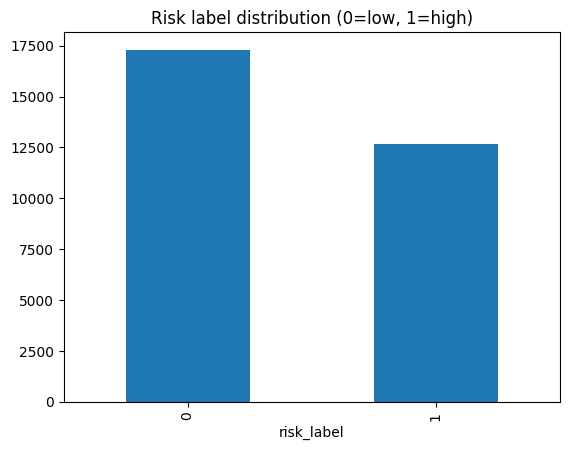

In [8]:

def build_risk_label(df_in: pd.DataFrame) -> pd.Series:
    abnormal_bp = df_in["RESULT_STAT_BP"].isin(["Low", "Mild High", "Moderate High", "Severe High", "High"])
    abnormal_sugar = df_in["RESULT_STAT_SUGAR"].notna() & (df_in["RESULT_STAT_SUGAR"] != "Normal")
    abnormal_bmi = df_in["RESULT_STAT_BMI"].notna() & (df_in["RESULT_STAT_BMI"] != "Normal")
    abnormal_spo2 = df_in["RESULT_STAT_SPO2"].isin(["Low", "Very low"])
    abnormal_pr = df_in["RESULT_STAT_PR"].isin(["High", "Low"])

    history = (
        (df_in.get("had_stroke", 0) == 1)
        | (df_in.get("has_cardiovascular_disease", 0) == 1)
        | (df_in.get("diabetic", False) == True)
        | (df_in.get("profile_hypertensive", False) == True)
    )
    return (abnormal_bp | abnormal_sugar | abnormal_bmi | abnormal_spo2 | abnormal_pr | history).astype(int)

df_clean["risk_label"] = build_risk_label(df_clean)

display(df_clean["risk_label"].value_counts().to_frame("count"))
display(df_clean["risk_label"].value_counts(normalize=True).to_frame("proportion"))

plt.figure()
df_clean["risk_label"].value_counts().plot(kind="bar")
plt.title("Risk label distribution (0=low, 1=high)")
plt.show()


In [10]:

df_fe = df_clean.copy()

# Age groups
bins = [-1, 17, 35, 50, 65, 200]
labels = ["0-17", "18-35", "36-50", "51-65", "66+"]
df_fe["age_group"] = pd.cut(df_fe["age"], bins=bins, labels=labels)

# Chronic count
flag_cols = ["had_stroke", "has_cardiovascular_disease", "diabetic", "profile_hypertensive"]
for c in flag_cols:
    if c not in df_fe.columns:
        df_fe[c] = 0

df_fe["chronic_condition_count"] = (
    df_fe["had_stroke"].fillna(0).astype(int)
    + df_fe["has_cardiovascular_disease"].fillna(0).astype(int)
    + df_fe["diabetic"].fillna(False).astype(int)
    + df_fe["profile_hypertensive"].fillna(False).astype(int)
)

# Measurement flags (missingness indicators)
df_fe["has_bmi_measurement"] = df_fe["BMI"].notna().astype(int)
df_fe["has_sugar_measurement"] = df_fe["SUGAR"].notna().astype(int)
df_fe["has_spo2_measurement"] = df_fe["SPO2"].notna().astype(int)

display(df_fe[["age", "age_group", "chronic_condition_count",
               "has_bmi_measurement", "has_sugar_measurement", "has_spo2_measurement"]].head())


,age,age_group,chronic_condition_count,has_bmi_measurement,has_sugar_measurement,has_spo2_measurement
0,19,18-35,0,0,0,1
1,20,18-35,0,0,0,0
2,42,36-50,0,0,0,0
3,64,51-65,0,0,1,0
4,23,18-35,0,0,0,0


In [11]:

TARGET = "risk_label"
ID_COL = "user_id"

leakage_cols = [
    # Direct measurements & statuses used in the label
    "SYSTOLIC","DIASTOLIC","RESULT_STAT_BP",
    "HEIGHT","WEIGHT","BMI","RESULT_STAT_BMI",
    "SUGAR","TAG_NAME","RESULT_STAT_SUGAR",
    "PULSE_RATE","RESULT_STAT_PR",
    "SPO2","RESULT_STAT_SPO2",
    "MUAC","RESULT_STAT_MUAC",
]

name_like_cols = ["profile_name","father_name","mother_name","birthday"]

drop_cols = [ID_COL, "household_id"] + leakage_cols + name_like_cols

X = df_fe.drop(columns=[TARGET] + drop_cols, errors="ignore")
y = df_fe[TARGET].astype(int)

print("X shape:", X.shape, "y shape:", y.shape)
display(X.head())


X shape: (29999, 15) y shape: (29999,)


,total_income,union_name,age,gender,is_freedom_fighter,had_stroke,has_cardiovascular_disease,disabilities_name,diabetic,profile_hypertensive,age_group,chronic_condition_count,has_bmi_measurement,has_sugar_measurement,has_spo2_measurement
0,Lower class,KOLA,19,Male,0,0,0,NaN,False,False,18-35,0,0,0,1
1,Lower class,KOLA,20,Female,0,0,0,NaN,False,False,18-35,0,0,0,0
2,Lower class,KOLA,42,Male,0,0,0,NaN,False,False,36-50,0,0,0,0
3,Lower class,KOLA,64,Female,0,0,0,NaN,False,False,51-65,0,0,1,0
4,Lower class,KOLA,23,Female,0,0,0,NaN,False,False,18-35,0,0,0,0


In [12]:

from sklearn.base import BaseEstimator, TransformerMixin

class QuantileClipper(BaseEstimator, TransformerMixin):
    """Clips numeric columns to training quantiles to reduce the effect of extreme outliers."""
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.lower_bounds_ = X.quantile(self.lower)
        self.upper_bounds_ = X.quantile(self.upper)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).clip(self.lower_bounds_, self.upper_bounds_, axis=1)
        return X.values

num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("clipper", QuantileClipper(lower=0.01, upper=0.99)),
    ("scaler", RobustScaler()),
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, num_cols),
        ("cat", categorical_pipeline, cat_cols),
    ],
    remainder="drop",
)

model = LogisticRegression(max_iter=1000, class_weight="balanced")

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Numeric cols: ['age', 'is_freedom_fighter', 'had_stroke', 'has_cardiovascular_disease', 'chronic_condition_count', 'has_bmi_measurement', 'has_sugar_measurement', 'has_spo2_measurement']
Categorical cols: ['total_income', 'union_name', 'gender', 'disabilities_name', 'diabetic', 'profile_hypertensive', 'age_group']


In [13]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train risk rate:", y_train.mean(), "Test risk rate:", y_test.mean())


Train: (23999, 15) Test: (6000, 15)
Train risk rate: 0.4231009625401058 Test risk rate: 0.4231666666666667


In [14]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {"precision": "precision", "recall": "recall", "f1": "f1", "roc_auc": "roc_auc"}

cv_res = cross_validate(pipe, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)

summary = {k: float(np.mean(v)) for k, v in cv_res.items() if k.startswith("test_")}
(pd.DataFrame([summary])
 .rename(columns=lambda c: c.replace("test_", ""))
 .T.rename(columns={0: "mean_cv_score"}))


,mean_cv_score
precision,0.636256
recall,0.504039
f1,0.562455
roc_auc,0.693461


Confusion matrix:
 [[2689  772]
 [1279 1260]]

Classification report:
               precision    recall  f1-score   support

           0      0.678     0.777     0.724      3461
           1      0.620     0.496     0.551      2539

    accuracy                          0.658      6000
   macro avg      0.649     0.637     0.638      6000
weighted avg      0.653     0.658     0.651      6000

ROC-AUC: 0.6807371602253616
PR-AUC : 0.6661498650288791


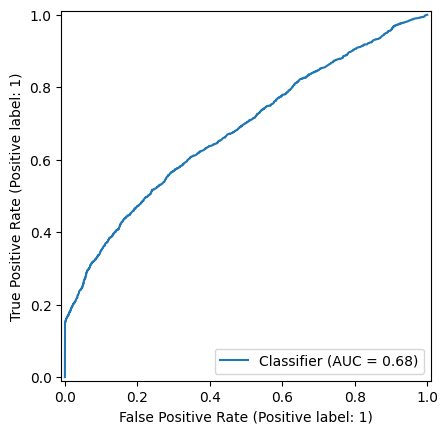

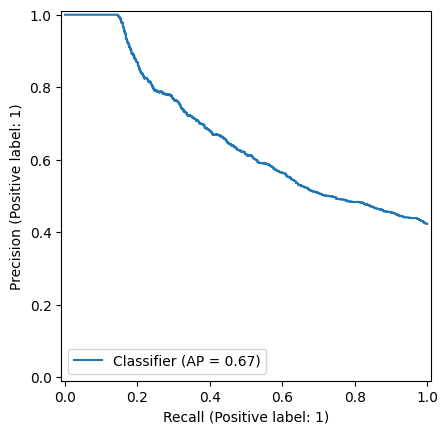

In [15]:

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

PrecisionRecallDisplay.from_predictions(y_test, y_proba)
plt.show()


In [16]:

# Collect indicators for validation (we use original df_fe rows)
test_rows = df_fe.loc[X_test.index].copy()

validation_cols = [
    "user_id",
    "SYSTOLIC","DIASTOLIC","RESULT_STAT_BP",
    "BMI","RESULT_STAT_BMI",
    "SUGAR","RESULT_STAT_SUGAR",
    "SPO2","RESULT_STAT_SPO2",
    "PULSE_RATE","RESULT_STAT_PR",
    "risk_label"
]

val = test_rows[validation_cols].copy()
val["y_pred"] = y_pred
val["proba"] = y_proba

top_high_risk = val[val["y_pred"] == 1].sort_values("proba", ascending=False).head(10)
display(top_high_risk)

example_id = int(top_high_risk.iloc[0]["user_id"])
print("Example user_id:", example_id)
display(val[val["user_id"] == example_id])


,user_id,SYSTOLIC,DIASTOLIC,RESULT_STAT_BP,BMI,RESULT_STAT_BMI,SUGAR,RESULT_STAT_SUGAR,SPO2,RESULT_STAT_SPO2,PULSE_RATE,RESULT_STAT_PR,risk_label,y_pred,proba
14400,487530,148.0,95.0,Mild High,NaN,NaN,21.10,High,NaN,NaN,84.0,Normal,1,1,0.999999
14920,666749,143.0,86.0,Mild High,NaN,NaN,10.16,High,NaN,NaN,80.0,Normal,1,1,0.999999
15652,745685,152.0,95.0,Mild High,NaN,NaN,6.75,HIGH (Borderline),NaN,NaN,96.0,Normal,1,1,0.999999
15872,861964,NaN,NaN,NaN,NaN,NaN,25.91,High,NaN,NaN,NaN,NaN,1,1,0.999999
21295,794598,126.0,77.0,Normal,NaN,NaN,7.19,Normal,NaN,NaN,97.0,Normal,1,1,0.999999
29309,3844493,NaN,NaN,NaN,NaN,NaN,7.80,Normal,NaN,NaN,NaN,NaN,1,1,0.999999
16068,889850,NaN,NaN,NaN,NaN,NaN,7.85,HIGH (Borderline),NaN,NaN,NaN,NaN,1,1,0.999999
14611,3804957,94.0,67.0,Normal,NaN,NaN,14.36,High,NaN,NaN,98.0,Normal,1,1,0.999999
17207,937948,NaN,NaN,NaN,NaN,NaN,8.01,High,NaN,NaN,NaN,NaN,1,1,0.999999
14489,488317,131.0,83.0,Normal,NaN,NaN,18.74,High,NaN,NaN,91.0,Normal,1,1,0.999999


Example user_id: 487530


,user_id,SYSTOLIC,DIASTOLIC,RESULT_STAT_BP,BMI,RESULT_STAT_BMI,SUGAR,RESULT_STAT_SUGAR,SPO2,RESULT_STAT_SPO2,PULSE_RATE,RESULT_STAT_PR,risk_label,y_pred,proba
14400,487530,148.0,95.0,Mild High,NaN,NaN,21.1,High,NaN,NaN,84.0,Normal,1,1,0.999999


In [17]:

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1) Post-processed dataset (clean + engineered + label)
post_processed_path = os.path.join(OUTPUT_DIR, "your_name_post_processed_dataset.csv")
df_fe.to_csv(post_processed_path, index=False)
print("Saved:", post_processed_path)

# 2) Predictions file (on test set)
pred_path = os.path.join(OUTPUT_DIR, "your_name_predictions_test.csv")
val.to_csv(pred_path, index=False)
print("Saved:", pred_path)

# 3) Requirements file (keep it minimal)
req_text = '''pandas
numpy
matplotlib
scikit-learn
openpyxl
'''
req_path = "requirements.txt"
with open(req_path, "w", encoding="utf-8") as f:
    f.write(req_text)

print("Saved:", req_path)


Saved: outputs\your_name_post_processed_dataset.csv
Saved: outputs\your_name_predictions_test.csv
Saved: requirements.txt


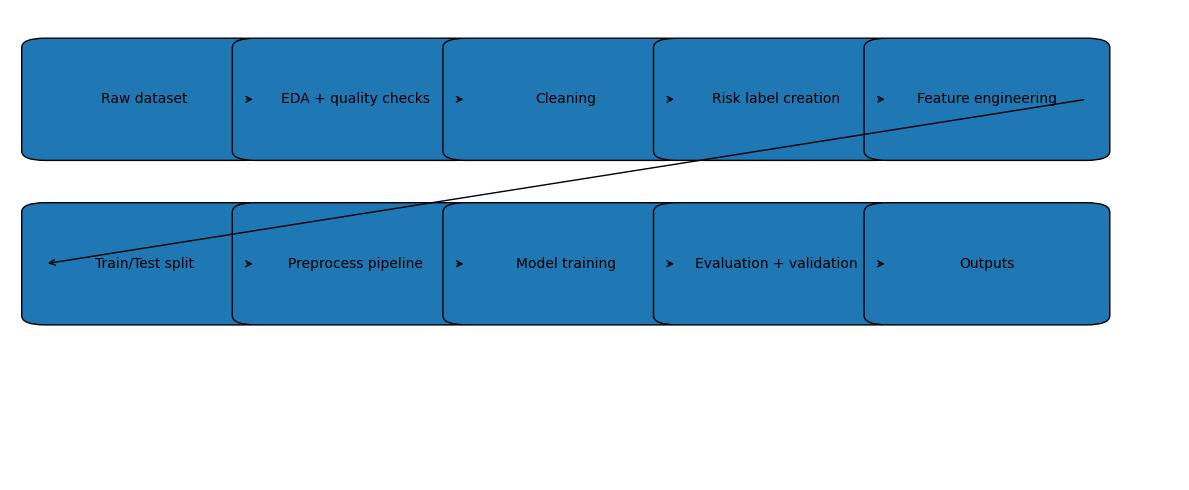

Saved diagram: outputs/methodology_diagram.png


In [18]:

import matplotlib.patches as patches

def draw_methodology_diagram(save_path="outputs/methodology_diagram.png"):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis("off")

    steps = [
        "Raw dataset",
        "EDA + quality checks",
        "Cleaning",
        "Risk label creation",
        "Feature engineering",
        "Train/Test split",
        "Preprocess pipeline",
        "Model training",
        "Evaluation + validation",
        "Outputs"
    ]

    x0, y0 = 0.03, 0.70
    w, h = 0.17, 0.22
    dx = 0.18

    for i, s in enumerate(steps):
        x = x0 + (i % 5) * dx
        y = y0 - (i // 5) * 0.35
        rect = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02")
        ax.add_patch(rect)
        ax.text(x + w/2, y + h/2, s, ha="center", va="center", fontsize=10)

        if i < len(steps) - 1:
            x_next = x0 + ((i + 1) % 5) * dx
            y_next = y0 - ((i + 1) // 5) * 0.35
            ax.annotate(
                "", xy=(x_next, y_next + h/2), xytext=(x + w, y + h/2),
                arrowprops=dict(arrowstyle="->", lw=1)
            )

    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()
    print("Saved diagram:", save_path)

draw_methodology_diagram()


In [20]:
# 1) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Detect column types (works if X is a DataFrame)
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

# 3) Preprocessing
num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(transformers=[
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# 4) Full model pipeline
clf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# 5) Fit
clf.fit(X_train, y_train)

# 6) Threshold tuning (NOW no NaNs issue)
proba = clf.predict_proba(X_test)[:, 1]

for thr in [0.50, 0.45, 0.40, 0.35, 0.30, 0.25]:
    pred = (proba >= thr).astype(int)
    print("\nThreshold:", thr)
    print("Confusion matrix:\n", confusion_matrix(y_test, pred))
    print(classification_report(y_test, pred, digits=3))


Threshold: 0.5
Confusion matrix:
 [[2709  752]
 [1291 1248]]
              precision    recall  f1-score   support

           0      0.677     0.783     0.726      3461
           1      0.624     0.492     0.550      2539

    accuracy                          0.659      6000
   macro avg      0.651     0.637     0.638      6000
weighted avg      0.655     0.659     0.652      6000


Threshold: 0.45
Confusion matrix:
 [[2009 1452]
 [ 887 1652]]
              precision    recall  f1-score   support

           0      0.694     0.580     0.632      3461
           1      0.532     0.651     0.586      2539

    accuracy                          0.610      6000
   macro avg      0.613     0.616     0.609      6000
weighted avg      0.625     0.610     0.612      6000


Threshold: 0.4
Confusion matrix:
 [[1210 2251]
 [ 472 2067]]
              precision    recall  f1-score   support

           0      0.719     0.350     0.471      3461
           1      0.479     0.814     0.603      2

In [21]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

rows = []
for thr in [0.50, 0.45, 0.40, 0.35, 0.30]:
    pred = (proba >= thr).astype(int)
    p, r, f1, _ = precision_recall_fscore_support(y_test, pred, average=None, labels=[0,1])
    acc = accuracy_score(y_test, pred)
    rows.append({
        "threshold": thr,
        "acc": acc,
        "precision_1": p[1],
        "recall_1": r[1],
        "f1_1": f1[1]
    })

thr_table = pd.DataFrame(rows).sort_values("threshold", ascending=False)
thr_table


,threshold,acc,precision_1,recall_1,f1_1
0,0.50,0.659500,0.624000,0.491532,0.549901
1,0.45,0.610167,0.532216,0.650650,0.585504
2,0.40,0.546167,0.478694,0.814100,0.602888
3,0.35,0.500000,0.454617,0.909413,0.606196
4,0.30,0.463500,0.439112,0.965735,0.603718


In [22]:
best_thr = 0.45

pred = (proba >= best_thr).astype(int)

check_df = X_test.copy()
check_df = check_df.reset_index(drop=True)
check_df["y_true"] = y_test.reset_index(drop=True) if hasattr(y_test, "reset_index") else y_test
check_df["risk_proba"] = proba
check_df["y_pred"] = pred

# Show top predicted high-risk
top = check_df.sort_values("risk_proba", ascending=False).head(15)

# Choose columns that exist in your data (adjust names as needed)
cols_to_show = [c for c in [
    "user_id",
    "risk_proba","y_pred","y_true",
    "systolic","diastolic","bp_status",
    "bmi","bmi_status",
    "sugar","sugar_status",
    "spo2","spo2_status",
    "pulse_rate","pulse_rate_status",
    "stroke","cardio_vascular_diseases","diabetic","hypertensive"
] if c in top.columns]

top[cols_to_show]


,risk_proba,y_pred,y_true,diabetic
4820,1.000000,1,1,True
3946,1.000000,1,1,True
1153,1.000000,1,1,False
5903,0.999999,1,1,True
2852,0.999999,1,1,True
4315,0.999999,1,1,True
5,0.999999,1,1,True
2960,0.999999,1,1,True
1831,0.999998,1,1,True
326,0.999998,1,1,True


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight="balanced_subsample",
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
rf_proba = rf.predict_proba(X_test)[:, 1]

# evaluate at same threshold 0.45
rf_pred = (rf_proba >= 0.45).astype(int)
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred, digits=3))


[[2143 1318]
 [1084 1455]]
              precision    recall  f1-score   support

           0      0.664     0.619     0.641      3461
           1      0.525     0.573     0.548      2539

    accuracy                          0.600      6000
   macro avg      0.594     0.596     0.594      6000
weighted avg      0.605     0.600     0.601      6000

